In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import decomposition
from sklearn import feature_selection

from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import neighbors

import seaborn as sns
from sqlalchemy import create_engine

In [2]:
import pandas as pd
%matplotlib inline

In [3]:
sns.set_context(font_scale=1.2)

In [4]:
engine = create_engine('sqlite:///../RBpipeline/rbogus-dev.db')

## Load the tables from the DB

Using a merge we can get the detected portion of the objects, with the
recovered data, and the correct simulated data.

In [5]:
dt_zps = pd.merge(pd.read_sql_table('Detected', engine),
                  pd.read_sql_query("""SELECT 
                                        Detected.id,
                                        Simulated.app_mag as sim_mag,
                                        Simulated.id as sim_id 
                                    FROM Detected
                                        LEFT JOIN Reals
                                            ON Detected.id==Reals.detected_id
                                        LEFT JOIN Simulated
                                            ON Simulated.id==Reals.simulated_id""", engine),
                                      on='id', suffixes=('',''))

dt_ois = pd.merge(pd.read_sql_table('DetectedOIS', engine),
                  pd.read_sql_query("""SELECT 
                                        DetectedOIS.id,
                                        Simulated.app_mag as sim_mag,
                                        Simulated.id as sim_id 
                                    FROM DetectedOIS
                                        LEFT JOIN RealsOIS
                                            ON DetectedOIS.id==RealsOIS.detected_id
                                        LEFT JOIN Simulated
                                            ON Simulated.id==RealsOIS.simulated_id""", engine),
                                      on='id', suffixes=('',''))

In [6]:
dt_zps.describe()

,id,NUMBER,FLUX_ISO,FLUXERR_ISO,MAG_ISO,MAGERR_ISO,FLUX_APER,FLUXERR_APER,MAG_APER,MAGERR_APER,...,ELLIPTICITY,CLASS_STAR,DELTAX,DELTAY,RATIO,ROUNDNESS,PEAK_CENTROID,image_id,sim_mag,sim_id
count,37511.00000,37511.000000,37511.000000,37511.000000,37511.000000,37511.000000,37511.000000,37511.000000,37511.000000,37511.000000,...,37511.000000,37511.000000,37511.000000,37511.000000,37511.000000,37511.000000,37511.000000,37511.000000,25014.000000,25014.000000
mean,18756.00000,27.473061,194.556446,5.220837,19.944220,0.066585,137.234509,4.386116,21.245749,1.396952,...,0.234230,0.027502,5.489430,5.593026,0.815168,1.469303,0.456333,350.978833,20.795768,14002.546294
std,10828.63731,15.778621,217.378596,1.890810,1.252145,0.049121,151.809545,0.019853,8.998857,11.241067,...,0.209386,0.083904,2.684481,2.726770,0.194928,0.655543,0.621877,201.542460,1.041749,8079.354205
min,1.00000,1.000000,8.074646,2.205838,16.962600,0.006100,-480.143700,3.454858,17.489400,0.004700,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000500,1.000000,19.000217,1.000000
25%,9378.50000,14.000000,43.208315,3.572966,18.945200,0.027750,35.190850,4.378651,19.329300,0.025700,...,0.059000,0.000000,3.000000,4.000000,0.666667,1.063099,0.145626,177.000000,19.893803,7004.250000
50%,18756.00000,27.000000,99.363580,5.043767,20.006900,0.053600,67.947950,4.388107,20.419600,0.070000,...,0.148000,0.001000,5.000000,5.000000,0.857143,1.173205,0.253165,352.000000,20.788595,14005.500000
75%,28133.50000,41.000000,264.194900,6.718171,20.911050,0.091200,185.475650,4.395314,21.133950,0.135300,...,0.393000,0.024000,7.000000,8.000000,1.000000,1.647137,0.530530,525.000000,21.682307,21008.500000
max,37511.00000,71.000000,1640.390000,19.335450,22.732200,0.298200,1009.842000,4.416481,99.000000,111.254200,...,0.917000,0.998000,51.000000,66.000000,1.000000,12.062745,13.621262,700.000000,22.994246,28000.000000


In [7]:
dt_ois.describe()

,id,NUMBER,FLUX_ISO,FLUXERR_ISO,MAG_ISO,MAGERR_ISO,FLUX_APER,FLUXERR_APER,MAG_APER,MAGERR_APER,...,ELLIPTICITY,CLASS_STAR,DELTAX,DELTAY,RATIO,ROUNDNESS,PEAK_CENTROID,image_id,sim_mag,sim_id
count,52169.000000,52169.000000,52169.000000,52169.000000,52169.000000,52169.000000,52169.000000,52169.000000,52169.000000,52169.000000,...,52169.000000,52169.000000,52169.000000,52169.000000,52169.000000,52169.000000,52169.000000,52169.000000,26837.000000,26837.000000
mean,26085.000000,37.862102,11029.545986,277.597717,15.685963,0.069601,7981.292370,246.739166,16.038973,0.236325,...,0.269367,0.040061,5.210930,5.217198,0.824542,1.535429,0.445452,350.352700,20.924063,13998.870142
std,15060.037434,21.683869,14719.205669,118.337288,1.304274,0.050127,10394.455673,12.849668,3.273458,3.691384,...,0.214232,0.133927,2.898757,2.897510,0.186940,0.610139,0.490395,202.209297,1.113755,8081.298170
min,1.000000,1.000000,432.793300,113.179900,12.365600,0.005600,-3657.656000,173.281800,12.812600,0.003600,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.001603,1.000000,19.000217,1.000000
25%,13043.000000,19.000000,2079.470000,179.319500,14.766300,0.028600,1837.356000,249.247100,15.142500,0.030900,...,0.069000,0.000000,3.000000,3.000000,0.714286,1.074646,0.119020,175.000000,19.960658,7000.000000
50%,26085.000000,38.000000,4619.419000,245.484400,15.838500,0.058700,3159.558000,249.878400,16.250900,0.085800,...,0.204000,0.002000,5.000000,5.000000,0.857143,1.256369,0.287342,350.000000,20.915832,14002.000000
75%,39127.000000,56.000000,12401.860000,365.800000,16.705100,0.095200,8770.167000,250.418200,16.839500,0.140600,...,0.465000,0.028000,7.000000,7.000000,1.000000,1.870796,0.662807,526.000000,21.881750,20994.000000
max,52169.000000,88.000000,113173.200000,1051.705000,18.409300,0.316900,74984.870000,254.905100,99.000000,99.000000,...,0.885000,0.994000,48.000000,53.000000,1.000000,8.736111,17.331401,700.000000,22.999940,28000.000000


In [8]:
dt_ois.IS_REAL = dt_ois.IS_REAL.astype(int)
dt_zps.IS_REAL = dt_zps.IS_REAL.astype(int)

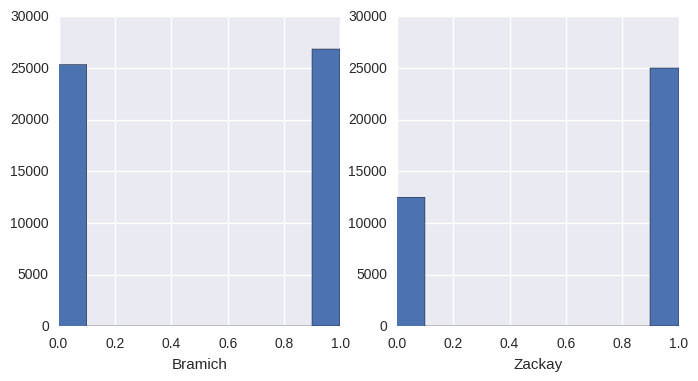

In [9]:
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.hist(dt_ois['IS_REAL'])
plt.xlabel('Bramich')
plt.subplot(122)
plt.hist(dt_zps['IS_REAL'])
plt.xlabel('Zackay')

In [10]:
dt_ois.columns

Index([u'id', u'NUMBER', u'FLUX_ISO', u'FLUXERR_ISO', u'MAG_ISO',
       u'MAGERR_ISO', u'FLUX_APER', u'FLUXERR_APER', u'MAG_APER',
       u'MAGERR_APER', u'FLUX_AUTO', u'FLUXERR_AUTO', u'MAG_AUTO',
       u'MAGERR_AUTO', u'BACKGROUND', u'THRESHOLD', u'FLUX_MAX', u'XMIN_IMAGE',
       u'YMIN_IMAGE', u'XMAX_IMAGE', u'YMAX_IMAGE', u'XPEAK_IMAGE',
       u'YPEAK_IMAGE', u'X_IMAGE', u'Y_IMAGE', u'X2_IMAGE', u'Y2_IMAGE',
       u'XY_IMAGE', u'CXX_IMAGE', u'CYY_IMAGE', u'CXY_IMAGE', u'A_IMAGE',
       u'B_IMAGE', u'THETA_IMAGE', u'MU_MAX', u'FLAGS', u'FWHM_IMAGE',
       u'ELONGATION', u'ELLIPTICITY', u'CLASS_STAR', u'DELTAX', u'DELTAY',
       u'RATIO', u'ROUNDNESS', u'PEAK_CENTROID', u'IS_REAL', u'image_id',
       u'sim_mag', u'sim_id'],
      dtype='object')

## Select the columns 

We select for both methods the columns related to every detection recovered data. 

There are 35 columns relevant, and this would be the biggest features set for training and testing.

In [11]:
d_ois = dt_ois[[ u'FLUX_ISO', u'FLUXERR_ISO', u'MAG_ISO',
       u'MAGERR_ISO', u'FLUX_APER', u'FLUXERR_APER', u'MAG_APER',
       u'MAGERR_APER', u'FLUX_AUTO', u'FLUXERR_AUTO', u'MAG_AUTO',
       u'MAGERR_AUTO', u'BACKGROUND', u'THRESHOLD', u'FLUX_MAX', u'X2_IMAGE', u'Y2_IMAGE',
       u'XY_IMAGE', u'CXX_IMAGE', u'CYY_IMAGE', u'CXY_IMAGE', u'A_IMAGE',
       u'B_IMAGE', u'THETA_IMAGE', u'MU_MAX', u'FLAGS', u'FWHM_IMAGE',
       u'ELONGATION', u'ELLIPTICITY', u'CLASS_STAR', u'DELTAX', u'DELTAY',
       u'RATIO', u'ROUNDNESS', u'PEAK_CENTROID']]

In [12]:
d_zps = dt_zps[[ u'FLUX_ISO', u'FLUXERR_ISO', u'MAG_ISO',
       u'MAGERR_ISO', u'FLUX_APER', u'FLUXERR_APER', u'MAG_APER',
       u'MAGERR_APER', u'FLUX_AUTO', u'FLUXERR_AUTO', u'MAG_AUTO',
       u'MAGERR_AUTO', u'BACKGROUND', u'THRESHOLD', u'FLUX_MAX', u'X2_IMAGE', u'Y2_IMAGE',
       u'XY_IMAGE', u'CXX_IMAGE', u'CYY_IMAGE', u'CXY_IMAGE', u'A_IMAGE',
       u'B_IMAGE', u'THETA_IMAGE', u'MU_MAX', u'FLAGS', u'FWHM_IMAGE',
       u'ELONGATION', u'ELLIPTICITY', u'CLASS_STAR', u'DELTAX', u'DELTAY',
       u'RATIO', u'ROUNDNESS', u'PEAK_CENTROID']]

In [13]:
len(d_zps.columns)

35

### Preprocesing
If we convert this to matrix (numpy arrays) we can then *preprocess* this data to become Machine treatable.

In [14]:
X_zps = d_zps.as_matrix()
X_ois = d_ois.as_matrix()

In [15]:
scaler_ois = preprocessing.StandardScaler().fit(X_ois)
scaler_zps = preprocessing.StandardScaler().fit(X_zps)

In [16]:
X_ois_scaled = scaler_ois.transform(X_ois)
X_zps_scaled = scaler_zps.transform(X_zps)

### Scaled

This scaling process transforms data to match distributions with zero mean and unit variance.

# Feature selection

Choosing a ranker
-----------------

It is important to know that feature selection is a general term for tossing the descriptors that doesn't work
as expected. This is not always mentioned, but in general one firstly should decide which ML algorithm will use,
for example a support vector machines. So, select a feature should be introduced tied to the algorithm applied for selection and perfomance testing. 

If it is not like this, one could provide misleading information, like jumping to the conclusion that there is no relation at all between a poor performer feature and the objective class, since the method for ML may be somehow not able to grab the information the feature provides. 

A quick notion of this is the non-linearities present in the profound behaviour of the reality, that we want to learn using linear kernels in a Support VM algorithm.

In [17]:
svc = svm.SVC(kernel='linear')

In [18]:
c45 = DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=20)

In [19]:
Y_ois = dt_ois['IS_REAL']
Y_zps = dt_zps['IS_REAL']

**Recursive feature elimination**

This a feature selection technique, that is completely supervised (in opposition to a Principal Component Analisys), and aims to elminate features that have poor description power in the chosen model environment.

For example in the code block below, we use a *c45* decision tree, and a *step* value of 3. This means, that we will train a *c45* algorithm tossing three random features, repeteadly, until we get a notion of which set of features get better scores (*f1* in this case). We repeat this using a 10 fold cross validation, and then decide which features we eliminate.

So it is a recursive technique that depends strongly on the *c45* election. It is clear that features that perform poor on a decision tree can be good descriptors for SVM for example. 

In [20]:
rfecv = feature_selection.RFECV(estimator=c45, step=3, cv=StratifiedKFold(10),
              scoring='f1')
rfecv.fit(X_ois_scaled, Y_ois)

RFECV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
   estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=20, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
   n_jobs=1, scoring='f1', step=3, verbose=0)

In [21]:
print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 8


In [22]:
d_ois.columns[rfecv.support_]

Index([u'MAGERR_ISO', u'FLUX_APER', u'MAGERR_APER', u'FLUX_AUTO',
       u'FLUXERR_AUTO', u'FLUX_MAX', u'B_IMAGE', u'FLAGS'],
      dtype='object')

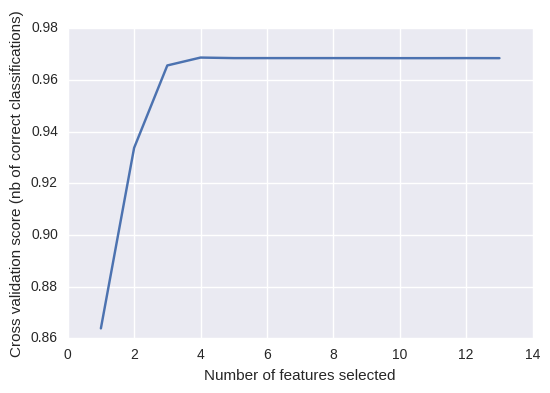

In [26]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [27]:
rfecv.support_

array([False, False, False,  True,  True, False, False,  True,  True,
        True, False, False, False, False,  True, False, False, False,
       False, False, False, False,  True, False, False,  True, False,
       False, False, False, False, False, False, False, False], dtype=bool)

In [28]:
dB = d_ois[d_ois.columns[rfecv.support_]]

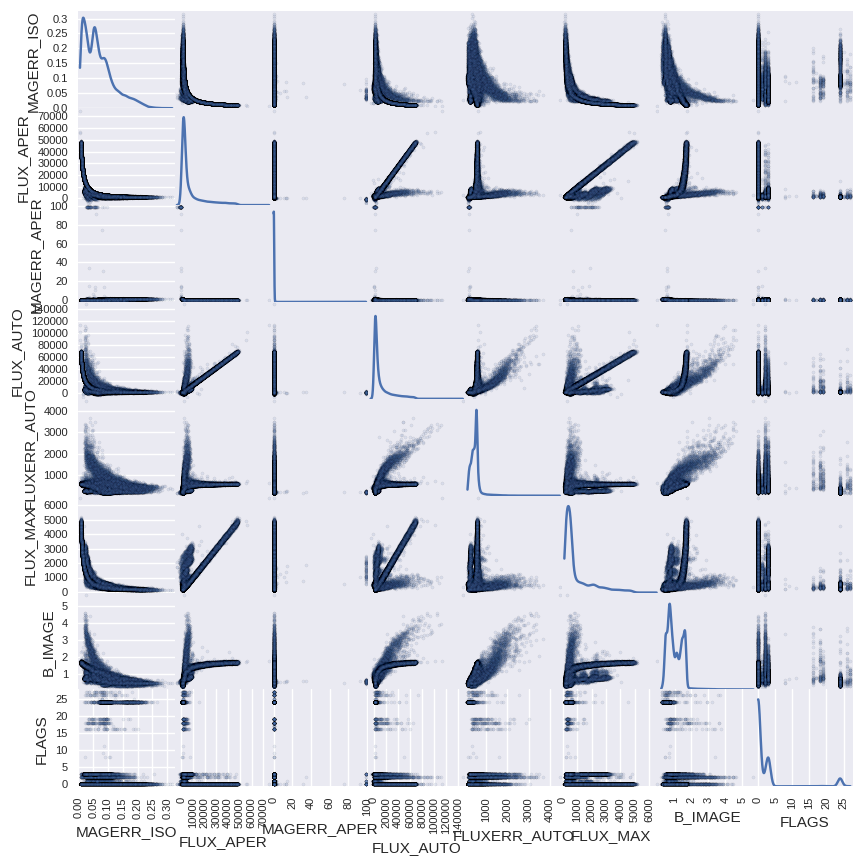

In [29]:
pd.scatter_matrix(dB, alpha=0.1, figsize=(10, 10), diagonal='kde')
plt.show()

In [30]:
rfecv = feature_selection.RFECV(estimator=c45, step=3, cv=StratifiedKFold(10),
              scoring='f1')

In [31]:
rfecv.fit(X_zps_scaled, Y_zps)

RFECV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
   estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=20, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
   n_jobs=1, scoring='f1', step=3, verbose=0)

In [32]:
print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 17


In [33]:
d_zps.columns[rfecv.support_]

Index([u'MAGERR_ISO', u'FLUX_APER', u'MAGERR_APER', u'FLUX_AUTO',
       u'FLUXERR_AUTO', u'MAG_AUTO', u'MAGERR_AUTO', u'BACKGROUND',
       u'THRESHOLD', u'FLUX_MAX', u'Y2_IMAGE', u'XY_IMAGE', u'A_IMAGE',
       u'FLAGS', u'FWHM_IMAGE', u'DELTAY', u'ROUNDNESS'],
      dtype='object')

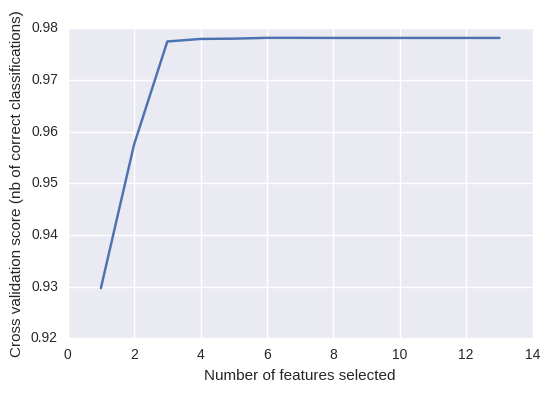

In [34]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [35]:
dZ = d_zps[d_zps.columns[rfecv.support_]]

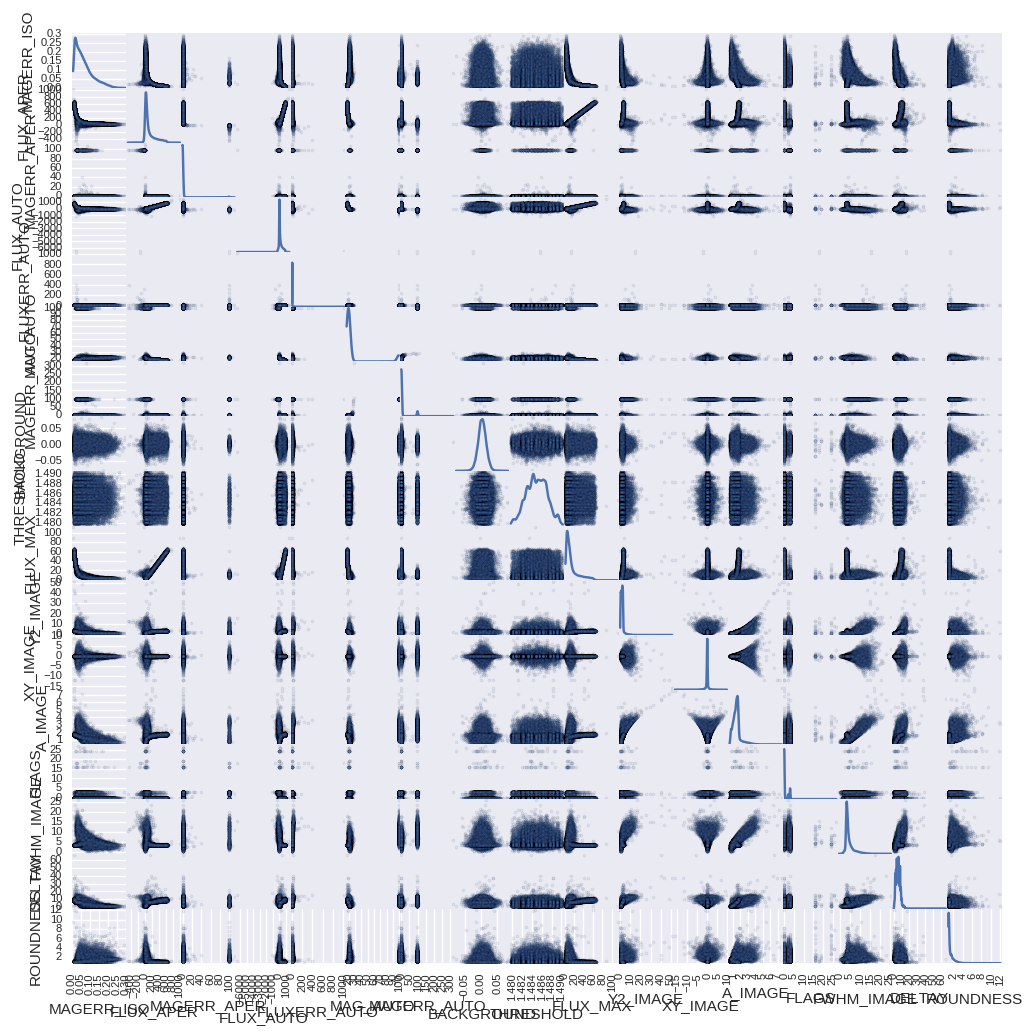

In [36]:
pd.scatter_matrix(dZ, alpha=0.1, figsize=(12, 12), diagonal='kde')
plt.show()

## Post processing

Repeat the scaling pre processing so we get the selected features normalized

In [37]:
X_zps = dZ.as_matrix()
X_ois = dB.as_matrix()

In [38]:
scaler_ois = preprocessing.StandardScaler().fit(X_ois)
scaler_zps = preprocessing.StandardScaler().fit(X_zps)

In [39]:
X_ois_scaled = scaler_ois.transform(X_ois)
X_zps_scaled = scaler_zps.transform(X_zps)

### Principal Component Analysis

In [40]:
pca = decomposition.PCA()

In [41]:
pca.fit(X_ois_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [42]:
X_ois_t = pca.transform(X_ois_scaled)

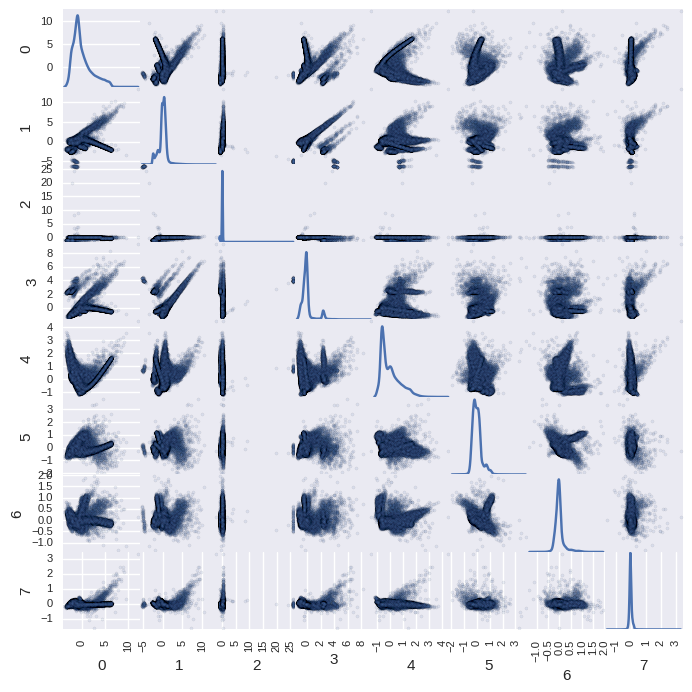

In [43]:
pd.scatter_matrix(pd.DataFrame(X_ois_t), alpha=0.1, figsize=(8, 8), diagonal='kde')
plt.show()

# Machine Learning perfomance comparison

## Comparing methods algorithm to algorithm

In [136]:
def experiment(clf, x, y, nfolds=10):
    skf = StratifiedKFold(n_splits=nfolds)
    probabilities = np.array([])
    predictions = np.array([])
    y_testing = np.array([])
    
    for train, test in skf.split(x, y):
        
        x_train = x[train]
        y_train = y[train]
        clf.fit(x_train, y_train)

        x_test = x[test]
        y_test = y[test]
        pr = clf.predict(x_test)
        probs = clf.predict_proba(x_test)[:, 0]

        probabilities = np.hstack([probabilities, probs])
        predictions = np.hstack([predictions, pr])
        y_testing = np.hstack([y_testing, y_test])

    print metrics.classification_report(y_testing, predictions)
    fpr, tpr, thresholds = metrics.roc_curve(y_testing, 1.-probabilities)
    roc_auc = metrics.auc(fpr, tpr)
    return {'fpr': fpr, 
            'tpr': tpr, 
            'thresh': thresholds, 
            'roc_auc': roc_auc, 
            'y_test': y_testing, 
            'predictions': predictions,
            'probabilities': probabilities, 
            'confusion_matrix': metrics.confusion_matrix(y_testing, predictions),
            }

### K-Nearest Neighbors


**OIS**

In [132]:
rslts_knn_ois_uniform = experiment(neighbors.KNeighborsClassifier(n_neighbors=3, weights='uniform'),
                                   X_ois_scaled, Y_ois.as_matrix())

             precision    recall  f1-score   support

        0.0       0.97      0.96      0.97     25332
        1.0       0.97      0.97      0.97     26837

avg / total       0.97      0.97      0.97     52169



**Zackay**

In [133]:
rslts_knn_zps_uniform = experiment(neighbors.KNeighborsClassifier(n_neighbors=3, weights='uniform'),
                                   X_zps_scaled, Y_zps.as_matrix())

             precision    recall  f1-score   support

        0.0       0.97      0.93      0.95     12497
        1.0       0.97      0.98      0.98     25014

avg / total       0.97      0.97      0.97     37511



### Support vector machines

**OIS**

In [137]:
Y = Y_ois.as_matrix()

In [138]:
skf = StratifiedKFold(n_splits=10)
predictions = np.array([])
y_testing = np.array([])
for train, test in skf.split(X_ois_scaled, Y):
    clf = svm.LinearSVC()
    
    x_train = X_ois_scaled[train]
    y_train = Y[train]
    clf.fit(x_train, y_train)
    
    x_test = X_ois_scaled[test]
    y_test = Y[test]
    pr = clf.predict(x_test)
    
    predictions = np.hstack([predictions, pr])
    y_testing = np.hstack([y_testing, y_test])

print metrics.classification_report(y_testing, predictions)

             precision    recall  f1-score   support

        0.0       0.96      0.97      0.96     25332
        1.0       0.97      0.97      0.97     26837

avg / total       0.97      0.97      0.97     52169



**Zackay**

In [139]:
Y = Y_zps.as_matrix()

In [140]:
skf = StratifiedKFold(n_splits=10)
predictions = np.array([])
y_testing = np.array([])
for train, test in skf.split(X_zps_scaled, Y):
    clf = svm.LinearSVC()
    
    x_train = X_zps_scaled[train]
    y_train = Y[train]
    clf.fit(x_train, y_train)
    
    x_test = X_zps_scaled[test]
    y_test = Y[test]
    pr = clf.predict(x_test)
    
    predictions = np.hstack([predictions, pr])
    y_testing = np.hstack([y_testing, y_test])

print metrics.classification_report(y_testing, predictions)

             precision    recall  f1-score   support

        0.0       0.98      0.95      0.97     12497
        1.0       0.98      0.99      0.98     25014

avg / total       0.98      0.98      0.98     37511



### Decision tree (gini)

**OIS**

In [141]:
rslts_ois_dtree_gini = experiment(DecisionTreeClassifier(max_leaf_nodes=10), X_ois_scaled, Y_ois.as_matrix())

             precision    recall  f1-score   support

        0.0       0.96      0.96      0.96     25332
        1.0       0.97      0.96      0.97     26837

avg / total       0.96      0.96      0.96     52169



**Zackay**

In [142]:
rslts_zps_dtree_gini = experiment(DecisionTreeClassifier(max_leaf_nodes=10), X_zps_scaled, Y_zps.as_matrix())

             precision    recall  f1-score   support

        0.0       0.95      0.95      0.95     12497
        1.0       0.97      0.98      0.98     25014

avg / total       0.97      0.97      0.97     37511



### Random forest

**OIS**

In [143]:
rslts_ois_rforest = experiment(RandomForestClassifier(n_estimators=100, min_samples_leaf=10), 
                               X_ois_scaled, Y_ois.as_matrix())

             precision    recall  f1-score   support

        0.0       0.97      0.98      0.98     25332
        1.0       0.98      0.98      0.98     26837

avg / total       0.98      0.98      0.98     52169



**Zackay**

In [144]:
rslts_zps_rforest = experiment(RandomForestClassifier(n_estimators=100, min_samples_leaf=10), 
                               X_zps_scaled, Y_zps.as_matrix())

             precision    recall  f1-score   support

        0.0       0.98      0.97      0.97     12497
        1.0       0.98      0.99      0.99     25014

avg / total       0.98      0.98      0.98     37511



### DecisionTreeClassifier (C45)

**OIS**

In [145]:
rslts_ois_c45 = experiment(DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=10), 
                               X_ois_scaled, Y_ois.as_matrix())

             precision    recall  f1-score   support

        0.0       0.97      0.95      0.96     25332
        1.0       0.96      0.97      0.97     26837

avg / total       0.96      0.96      0.96     52169



**Zackay**

In [146]:
rslts_zps_c45 = experiment(DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=10), 
                               X_zps_scaled, Y_zps.as_matrix())

             precision    recall  f1-score   support

        0.0       0.97      0.93      0.95     12497
        1.0       0.97      0.99      0.98     25014

avg / total       0.97      0.97      0.97     37511



### ROC curve

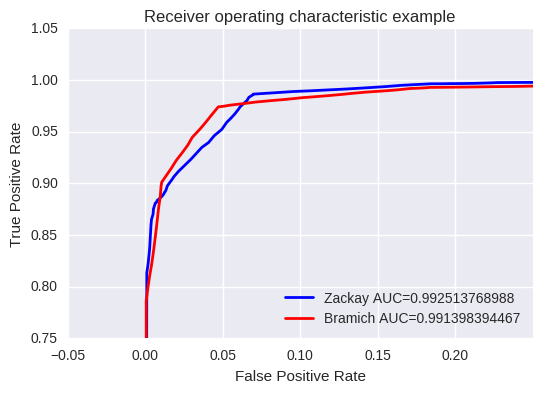

In [126]:
fpr, tpr, thresholds = metrics.roc_curve(y_testing_zps, 1.-probabilities_zps)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='blue', label='Zackay AUC={}'.format(roc_auc))

fpr, tpr, thresholds = metrics.roc_curve(y_testing_ois, 1.-probabilities_ois)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='red', label='Bramich AUC={}'.format(roc_auc))

#plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Luck')
plt.xlim([-0.05, 0.25])
plt.ylim([0.75, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic example')

## Export tree

In [65]:
clf = DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=10)
clf.fit(X_ois_t, Y)

ValueError: Number of labels=37511 does not match number of samples=52169

In [ ]:
from sklearn.tree import export_graphviz

In [ ]:
export_graphviz(clf, 'tree.dot')